<hr/>

# Loan Repayment Prediction

<hr/>

Mengingat data historis pinjaman yang diberikan dengan informasi tentang apakah peminjam gagal (charge-off), dapatkah kita membangun model yang dapat memprediksi apakah peminjam akan membayar kembali pinjamannya? Dengan cara ini di masa depan ketika kami mendapatkan pelanggan potensial baru, kami dapat menilai apakah mereka akan membayar kembali pinjamannya atau tidak.

## Table of Contents

* [1. Setup and Import](#1)
* [2. Limit the Feature Space](#2)
 * [2.1 Drop features missing more than 30% data](#2.1)
 * [2.2 Only keep loan features known to potential investors](#2.2)
* [3. Data Analysis and Pre-processing](#3)
 * [3.1 Overlook on Data](#3.1)
 * [3.2  Pre-processing on each Variable](#3.2)
* [4. More Pre-processing](#4)
 * [4.1 Convert loan status to 0/1 charge-off indicator](#4.1)
 * [4.2 Create dummy variables](#4.2)
 * [4.3 Train/test split](#4.3)
* [5. Linear Dependence of Charge-off on the Predictors](#5)
 * [5.1 Pearson correlation](#5.1)
* [6. Model Training and Testing](#6)
 * [6.1 Neural Network](#6.1)
 * [6.2 Logistic regression with SGD training](#6.2)
 * [6.3 Random forest classifier](#6.3)
 * [6.4 Tune hyperparameters on the chosen model more finely](#6.4)
 * [6.5 Test set evaluation](#6.5)
* [7. Conclusion](#7)

<a id="1"></a>
# 1. Setup and Import
<hr>

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

# scaling and train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
pd.set_option("display.precision", 4) # Show numbers only with 2 decimal places

# machine learning algorithm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# creating a model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# evaluation on test data
from sklearn.metrics import classification_report,confusion_matrix


In [2]:
# Create dataframe from dataset file
loans = pd.read_csv('loan_data_2007_2014_1.csv', index_col=0)
loans.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,20,43,44,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5.861.071.414,5831.78,5000.00,861.07,0,0.0,0,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3.003.653.644,3003.65,2400.00,603.65,0,0.0,0,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,1.222.630.221,12226.30,10000.00,2209.33,16.97,0.0,0,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some ex

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  object 
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [4]:
loans.isna().sum().sort_values()

id                                  0
addr_state                          0
dti                                 0
revol_bal                           0
initial_list_status                 0
out_prncp_inv                       0
total_pymnt                         0
total_pymnt_inv                     0
total_rec_prncp                     0
total_rec_int                       0
total_rec_late_fee                  0
recoveries                          0
collection_recovery_fee             0
last_pymnt_amnt                     0
policy_code                         0
application_type                    0
zip_code                            0
purpose                             0
out_prncp                           0
funded_amnt                         0
sub_grade                           0
grade                               0
installment                         0
int_rate                            0
term                                0
member_id                           0
funded_amnt_

In [5]:
loans.shape

(466285, 74)

<a id="2"></a>
# 2. Limit the Feature Space

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

<a id="2.1"></a>
## 2.1 Drop features missing more than 30% data

In [6]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)
missing_fractions.head(10)

inq_last_12m                 1.0
verification_status_joint    1.0
open_acc_6m                  1.0
open_il_6m                   1.0
open_il_12m                  1.0
open_il_24m                  1.0
mths_since_rcnt_il           1.0
dti_joint                    1.0
total_bal_il                 1.0
annual_inc_joint             1.0
dtype: float64

Text(0, 0.5, 'Feature count')

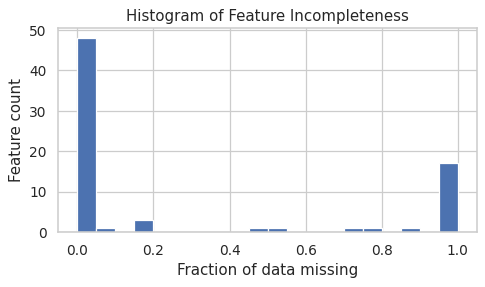

In [7]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

Dari histogram di atas, kami melihat ada kesenjangan besar antara fitur yang tidak memiliki "beberapa" data (<20%) dan yang tidak memiliki "banyak" data (>40%). Karena umumnya sangat sulit untuk secara akurat mengaitkan data dengan lebih dari 30% nilai yang hilang, kami menghapus kolom tersebut. Pertama-tama simpan semua variabel yang kehilangan lebih dari 30% data dalam data frame.

In [8]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)
print("\n\n Drop Features: ", len(drop_list))

['all_util', 'annual_inc_joint', 'desc', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'next_pymnt_d', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il', 'total_cu_tl', 'verification_status_joint']


 Drop Features:  22


In [9]:
# Drop these features
loans.drop(labels=drop_list, axis=1, inplace=True)

In [10]:
loans.shape

(466285, 52)

<a id="2.2"></a>
## 2.2 Only keep loan features known to potential investors

In [11]:
print(sorted(loans.columns))

['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'member_id', 'open_acc', 'out_prncp', 'out_prncp_inv', 'policy_code', 'pub_rec', 'purpose', 'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'tot_coll_amt', 'tot_cur_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim', 'url', 'verification_status', 'zip_code']


Untuk masing-masing fitur ini, kami memeriksa deskripsi di Kamus Data dan hanya menyimpan fitur yang akan tersedia bagi investor yang mempertimbangkan investasi dalam pinjaman. Ini termasuk fitur dalam aplikasi pinjaman, dan fitur apa pun yang ditambahkan oleh LendingClub ketika daftar pinjaman diterima, seperti peringkat pinjaman dan tingkat bunga.

Saya menggunakan pengetahuan terbaik yang tersedia untuk menentukan fitur pinjaman mana yang diketahui oleh calon investor. Saya bukan investor di LendingClub, jadi pengetahuan saya tentang proses investasi LendingClub tidak tepat. Jika ragu, saya salah dalam menjatuhkan fitur tersebut.

In [12]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']
print("Keep features: ", len(keep_list))

Keep features:  31


In [13]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

print("\n\nNumber of features needed to be dropped: ",len(drop_list))

['member_id', 'funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']


Number of features needed to be dropped:  25


In [14]:
loans.drop(labels=drop_list, axis=1, inplace=True)
loans.shape

(466285, 27)

<a id="3"></a>
# 3. Data Analysis and Pre-processing

* Overlook on Data
* Pre-processing on each Variable

<a id="3.1"></a>
## 3.1 Overlook on Data

In [15]:
print("Records: ", loans.shape[0], "\nFeatures: ", loans.shape[1])
print("\nInformation of Dataset\n-------")
loans.info()

Records:  466285 
Features:  27

Information of Dataset
-------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   466285 non-null  int64  
 1   loan_amnt            466285 non-null  int64  
 2   term                 466285 non-null  object 
 3   int_rate             466285 non-null  float64
 4   installment          466285 non-null  float64
 5   grade                466285 non-null  object 
 6   sub_grade            466285 non-null  object 
 7   emp_title            438697 non-null  object 
 8   emp_length           445277 non-null  object 
 9   home_ownership       466285 non-null  object 
 10  annual_inc           466281 non-null  float64
 11  verification_status  466285 non-null  object 
 12  issue_d              466285 non-null  object 
 13  loan_status          466285 non-null  object 
 14  purp

In [16]:
loans.describe(include=np.object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,466265,466285,466285,466256,466285,466285
unique,2,7,35,205475,11,6,3,91,9,14,63099,888,50,664,2,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Current,debt_consolidation,Debt consolidation,945xx,CA,Oct-2000,f,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,274195,164075,5304,71450,3674,303005,466285


In [17]:
# Target Variable
loans['loan_status'].value_counts(dropna=False)

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Kami mencoba mempelajari perbedaan fitur antara pinjaman yang telah dilunasi (fully paid) atau dilunasi (charge off). Kami tidak akan mempertimbangkan pinjaman yang lancar (current), tidak memenuhi kebijakan kredit (don't meet the credit policy), gagal bayar (default), atau statusnya hilang. Jadi kami hanya menyimpan pinjaman dengan status "Fully Paid" atau "Charged off".

In [18]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

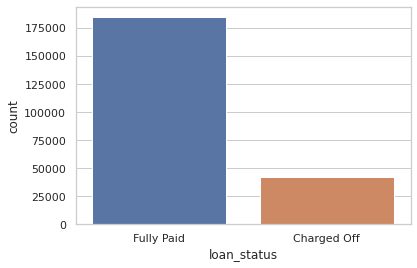

In [19]:
sns.countplot(x='loan_status',data=loans)

In [20]:
# Categories in percentage
loans['loan_status'].value_counts(normalize=True, dropna=False)*100

Fully Paid     81.3062
Charged Off    18.6938
Name: loan_status, dtype: float64

* Ini adalah masalah ketidakseimbangan, karena kita memiliki lebih banyak entri orang yang melunasi pinjaman mereka daripada orang yang tidak membayar kembali.
* Kami dapat berharap untuk mungkin melakukannya dengan sangat baik dalam hal akurasi tetapi presisi dan recall kami akan menjadi metrik sebenarnya yang harus kami evaluasi berdasarkan model.

<a id="3.2"></a>
## 3.2 Pre-processing on each Variable

Kami akan memeriksa setiap fitur satu per satu, dan melakukan hal berikut:

1. Drop fitur jika tidak digunakan untuk prediksi status peminjaman.
2. Lihat statistik ringkasan dan visualisasikan data, dengan plot terhadap status pinjaman.
3. Ubah fitur agar berguna untuk pemodelan, jika perlu.

Kami mendefinisikan fungsi untuk memplot variabel dan membandingkan dengan status pinjaman:

In [21]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

Print the remaining features for future reference:

In [22]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type']


### 3.2.1 id

Data Dictionary: "ID yang ditugaskan LC yang unik untuk daftar pinjaman."

Are all the IDs unique?

In [23]:
loans['id'].describe()

count    2.2721e+05
mean     8.3306e+06
std      9.0797e+06
min      5.4734e+04
25%      1.3818e+06
50%      5.1664e+06
75%      1.2246e+07
max      3.7854e+07
Name: id, dtype: float64

Ya, mereka semua unik. ID tidak berguna untuk pemodelan, baik sebagai variabel kategori (terlalu banyak nilai yang berbeda) atau sebagai variabel numerik (ID sangat bervariasi besarnya, kemungkinan tanpa signifikansi apa pun), jadi kami menghapus variabel ini.

In [24]:
loans.drop('id', axis=1, inplace=True)

###3.2.2 Correlation

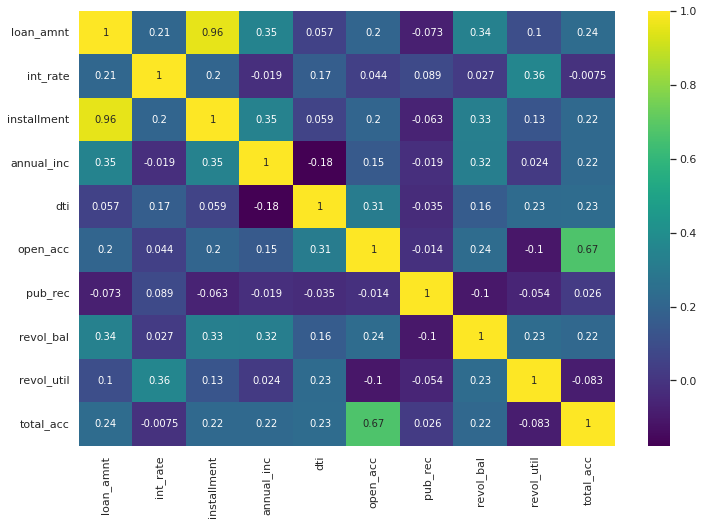

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(loans.corr(), annot=True, cmap='viridis')

Kami melihat korelasi yang hampir sempurna antara fitur "loan_amnt" dengan "installment". Kami akan mengeksplorasi fitur ini lebih lanjut. Cetak deskripsi mereka dan lakukan scatterplot di antara mereka.

* Apakah hubungan ini masuk akal bagi Anda?
* Apakah menurut kami ada informasi duplikat di sini?

### 3.2.3 loan_amnt

Data Dictionary: "Jumlah pinjaman yang terdaftar yang diterapkan oleh peminjam. Jika pada suatu titik waktu, departemen mengurangi jumlah pinjaman, maka itu akan tercermin dalam nilai."

In [26]:
loans['loan_amnt'].describe()

count    227214.0000
mean      13458.2299
std        8046.0907
min         500.0000
25%        7200.0000
50%       12000.0000
75%       18000.0000
max       35000.0000
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$35,000, with a median of \$12,000.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


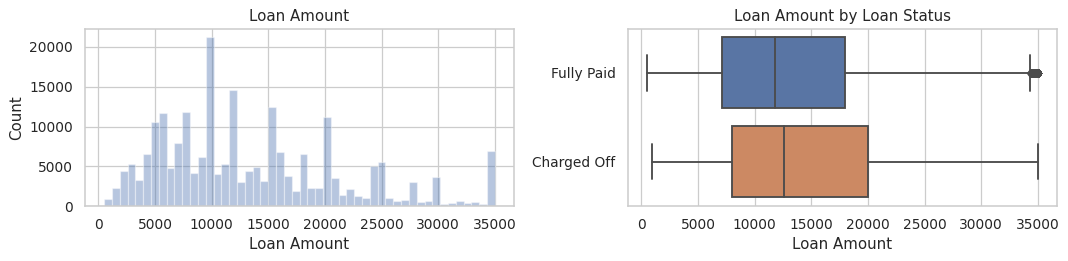

In [27]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [28]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,14518.7587,8373.1848,900.0,8000.0,12600.0,20000.0,35000.0
Fully Paid,184739.0,13214.3942,7949.0303,500.0,7125.0,11800.0,18000.0,35000.0


### 3.2.4 installment
<a id="3.2.4"></a>

Data Dictionary: "Pembayaran bulanan terutang oleh peminjam jika pinjaman berasal."

In [29]:
loans['installment'].describe()

count    227214.000
mean        416.490
std         243.507
min          15.690
25%         239.100
50%         365.010
75%         545.160
max        1408.130
Name: installment, dtype: float64

Installments range from \$15.69 to \$1,408, with a median of \$365.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


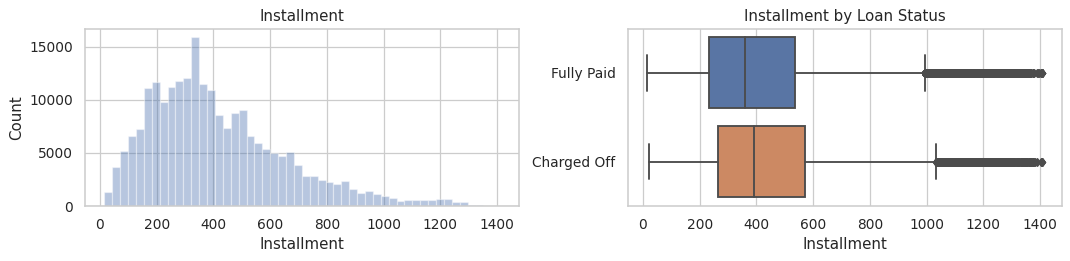

In [30]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [31]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,439.9927,246.2252,21.62,264.610,391.26,572.47,1408.13
Fully Paid,184739.0,411.0862,242.5566,15.69,233.185,358.77,537.34,1408.13


Pinjaman yang dikenakan biaya rata-rata memiliki cicilan $30 lebih tinggi.

### 3.2.5 term

Data Dictionary: "Jumlah pembayaran pinjaman. Nilai dalam bulan dan dapat berupa 36 atau 60."

In [32]:
loans['term'].value_counts(dropna=False)

 36 months    178556
 60 months     48658
Name: term, dtype: int64

Convert `term` to integers.

In [33]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))
loans['term'].value_counts(normalize=True)

36    0.7858
60    0.2142
Name: term, dtype: float64

Compare the charge-off rate by loan period:

In [34]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.1538
60    0.3087
Name: loan_status, dtype: float64

Sekitar 78% dari pinjaman yang diselesaikan memiliki jangka waktu tiga tahun, dan sisanya memiliki jangka waktu lima tahun. Pinjaman dengan periode lima tahun lebih dari dua kali lebih mungkin untuk ditagih daripada pinjaman dengan periode tiga tahun.

### 3.2.6 int_rate

Data Dictionary: "Suku bunga pinjaman."

In [35]:
loans['int_rate'].describe()

count    227214.0000
mean         13.7687
std           4.3835
min           5.4200
25%          10.7400
50%          13.6100
75%          16.4500
max          26.0600
Name: int_rate, dtype: float64

Interest rates range from 5.42% to 26% (!) with a median of 13.6%.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


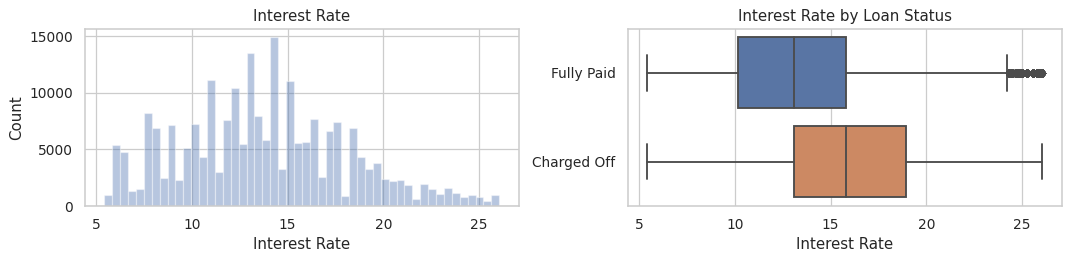

In [36]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [37]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,15.9988,4.2903,5.42,13.06,15.80,18.92,26.06
Fully Paid,184739.0,13.2559,4.2420,5.42,10.16,13.11,15.80,26.06


### 3.2.7 grade, sub_grade

Data Dictionary for `grade`: "LendingClub menetapkan peringkat pinjaman."

Data Dictionary for `sub_grade`: "LendingClub menetapkan subgrade pinjaman."

Apa kemungkinan nilai `grade` dan `sub_grade`?

In [38]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [39]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [40]:
loans.drop('grade', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


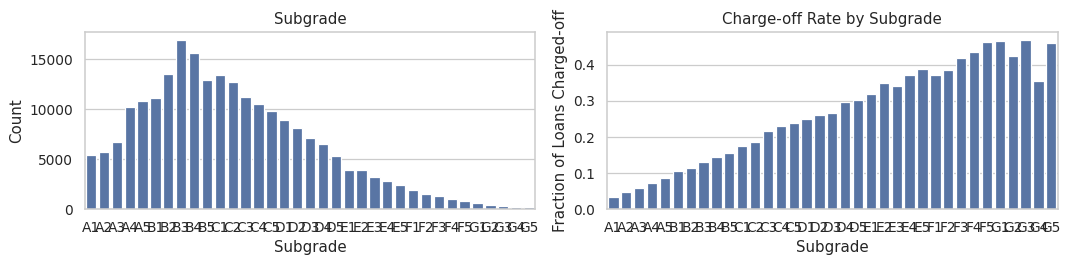

In [41]:
plot_var('sub_grade', 'Subgrade', continuous=False)

Ada kecenderungan yang jelas dari kemungkinan charge-off yang lebih tinggi karena sub-grade memburuk.

### 3.2.8 emp_title

Data Dictionary: "Jabatan yang diberikan oleh Peminjam saat mengajukan pinjaman."

In [42]:
loans['emp_title'].describe()

count      214511
unique     124991
top       Teacher
freq         1527
Name: emp_title, dtype: object

Ada terlalu banyak judul pekerjaan yang berbeda agar fitur ini tidak berguna, jadi harus di drop.

In [43]:
loans.drop(labels='emp_title', axis=1, inplace=True)

### 3.2.9 emp_length

Data Dictionary: "Lama kerja dalam tahun. Nilai yang mungkin antara 0 dan 10 di mana 0 berarti kurang dari satu tahun dan 10 berarti sepuluh tahun atau lebih." Data sebenarnya tidak cocok dengan deskripsi ini:

In [44]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year       15162
10+ years    68028
2 years      21239
3 years      18428
4 years      14693
5 years      16598
6 years      13659
7 years      12884
8 years      10537
9 years       8523
< 1 year     18790
NaN           8673
Name: emp_length, dtype: int64

Perhatikan: ada 8.673 pinjaman tanpa data masa kerja (NaN).

Convert `emp_length` to integers:

In [45]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [46]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [47]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [48]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [49]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.0     18790
1.0     15162
2.0     21239
3.0     18428
4.0     14693
5.0     16598
6.0     13659
7.0     12884
8.0     10537
9.0      8523
10.0    68028
NaN      8673
Name: emp_length, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


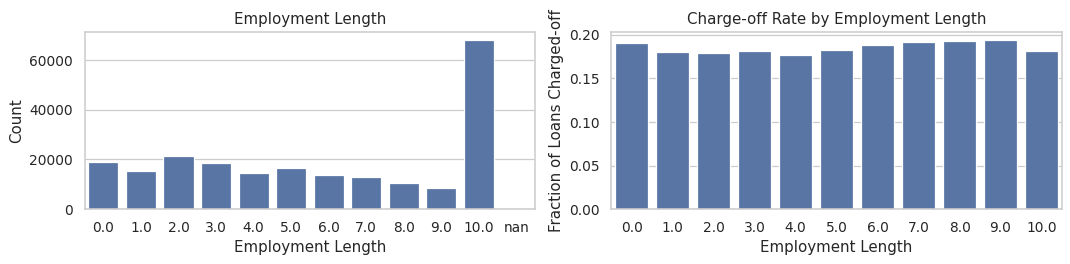

In [50]:
plot_var('emp_length', 'Employment Length', continuous=False)

In [51]:
loans.drop('emp_length', axis=1, inplace=True)

Status pinjaman tampaknya tidak jauh berbeda dengan rata-rata lama kerja, kecuali sedikit penurunan biaya untuk peminjam dengan masa kerja lebih dari 10 tahun.

### 3.2.10 home_ownership

Data Dictionary: "Status kepemilikan rumah yang diberikan oleh peminjam pada saat pendaftaran atau diperoleh dari laporan kredit. kategori nilai: RENT, OWN, MORTGAGE, OTHER."

In [52]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    112020
RENT         95931
OWN          19078
OTHER          141
NONE            43
ANY              1
Name: home_ownership, dtype: int64

Mengganti nilai `ANY` dan `NONE` dengan `OTHER`:

In [53]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [54]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    112020
RENT         95931
OWN          19078
OTHER          185
Name: home_ownership, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


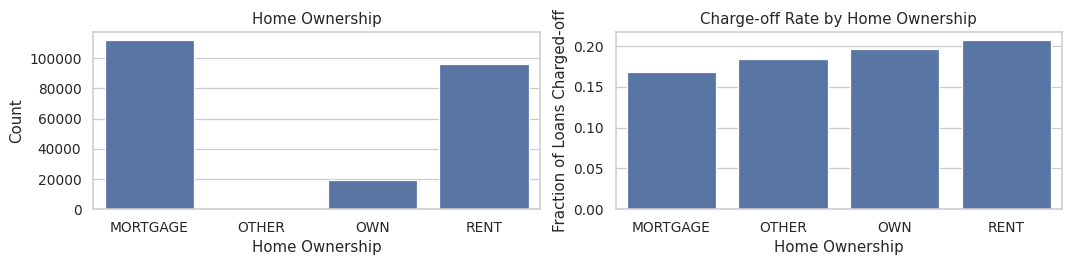

In [55]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

Tampaknya ada perbedaan besar dalam tarif charge-off berdasarkan status kepemilikan rumah. Penyewa dan pemilik rumah memiliki kemungkinan charge-off yang lebih tinggi. Mari kita bandingkan tarif charge-off:

In [56]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.1678
OTHER       0.1838
OWN         0.1958
RENT        0.2075
Name: loan_status, dtype: float64

### 3.2.11 annual_inc

Data Dictionary: "Pendapatan tahunan yang dilaporkan sendiri yang disediakan oleh peminjam selama pendaftaran."

In [57]:
loans['annual_inc'].describe()

count    2.2721e+05
mean     7.2035e+04
std      5.5291e+04
min      3.0000e+03
25%      4.5000e+04
50%      6.2000e+04
75%      8.6000e+04
max      7.1418e+06
Name: annual_inc, dtype: float64

Pendapatan tahunan berkisar dari \$3 hingga \$7.141.000, dengan median \$62.000. Karena rentang pendapatan yang besar, kita harus mengambil transformasi log dari variabel pendapatan tahunan.

In [58]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [59]:
loans.drop('annual_inc', axis=1, inplace=True)

In [60]:
loans['log_annual_inc'].describe()

count    227214.0000
mean          4.7955
std           0.2250
min           3.4773
25%           4.6532
50%           4.7924
75%           4.9345
max           6.8538
Name: log_annual_inc, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


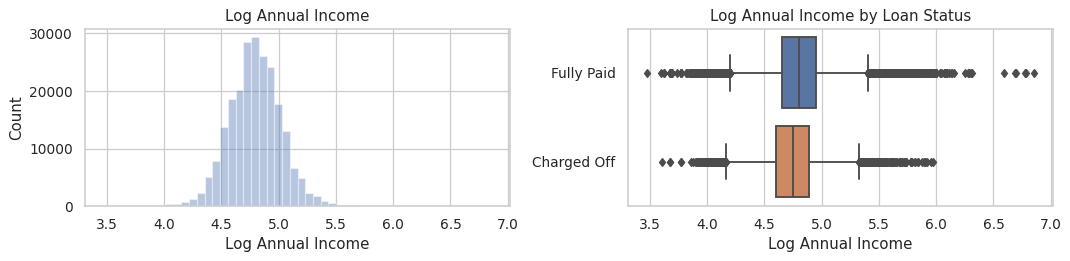

In [61]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [62]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,4.7533,0.2194,3.6108,4.6021,4.7482,4.8921,5.9694
Fully Paid,184739.0,4.8052,0.2252,3.4773,4.6532,4.8062,4.9542,6.8538


### 3.2.12 verification_status

Data Dictionary: "Menunjukkan jika pendapatan diverifikasi oleh [Lending Club], tidak diverifikasi, atau jika sumber pendapatan diverifikasi."

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


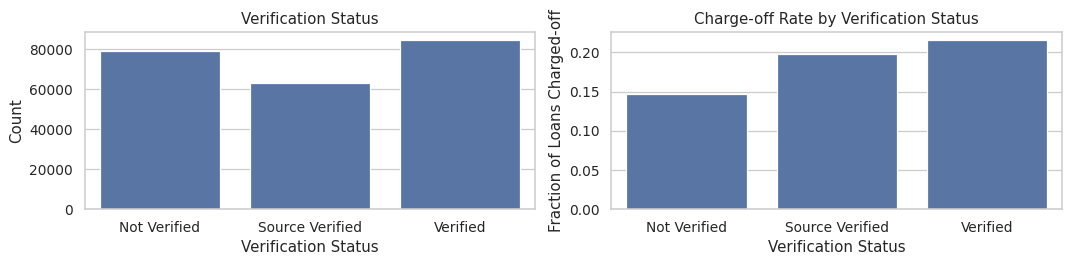

In [63]:
plot_var('verification_status', 'Verification Status', continuous=False)

### 3.2.13 issue_d

Data Dictionary: "Bulan di mana pinjaman itu didanai."




Karena kami hanya menggunakan variabel yang tersedia untuk investor sebelum pinjaman didanai, `issue_d` tidak akan disertakan dalam model akhir. Kami menyimpannya untuk saat ini hanya untuk melakukan train/tes split nanti, lalu kami akan drop.

### 3.2.14 purpose

Data Dictionary: "Kategori yang disediakan oleh peminjam untuk permintaan pinjaman."

In [64]:
loans['purpose'].value_counts()

debt_consolidation    132276
credit_card            45549
home_improvement       13202
other                  12834
major_purchase          5720
small_business          4486
car                     3391
medical                 2577
wedding                 1954
moving                  1797
house                   1449
vacation                1403
educational              325
renewable_energy         251
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [65]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
car                   0.1253
wedding               0.1356
major_purchase        0.1413
home_improvement      0.1610
credit_card           0.1620
educational           0.1723
vacation              0.1803
house                 0.1843
debt_consolidation    0.1953
medical               0.2029
renewable_energy      0.2032
other                 0.2159
moving                0.2187
small_business        0.2947
Name: loan_status, dtype: float64

Perhatikan bahwa hanya 12% dari pinjaman yang telah diselesaikan untuk pernikahan yang telah ditagih, tetapi 30% dari pinjaman usaha kecil yang telah diselesaikan telah ditagih.

### 3.2.15 title

Data Dictionary: "Judul pinjaman yang diberikan oleh peminjam."

In [66]:
loans['title'].describe()

count                 227201
unique                 47898
top       Debt consolidation
freq                   55995
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [67]:
loans['title'].value_counts().head(10)

Debt consolidation           55995
Credit card refinancing      18258
Debt Consolidation           11092
Home improvement              5013
Other                         4593
Consolidation                 3570
debt consolidation            3215
Debt Consolidation Loan       3058
Credit Card Consolidation     1626
Major purchase                1615
Name: title, dtype: int64

Ada 55995 judul berbeda dalam kumpulan data, dan berdasarkan 10 judul teratas, variabel `purpose` tampaknya sudah berisi informasi ini. Jadi kita drop variabel `title`.

In [68]:
loans.drop('title', axis=1, inplace=True)

### 3.2.16 zip-code, addr_state

Data Dictionary for `zip_code`: "3 angka pertama kode pos yang diberikan oleh peminjam dalam aplikasi pinjaman." (Sudah di drop dari data frame)

Data Dictionary for `addr_state`: "Negara yang disediakan oleh peminjam dalam aplikasi pinjaman."

In [69]:
loans['zip_code'].sample(5)

37752     079xx
124319    323xx
428939    322xx
140312    190xx
54890     774xx
Name: zip_code, dtype: object

In [70]:
loans['zip_code'].nunique()

870

In [71]:
loans['addr_state'].sample(5)

130891    MI
261465    TX
103998    IN
90961     MN
160820    CA
Name: addr_state, dtype: object

In [72]:
loans.drop(labels='zip_code', axis=1, inplace=True)

In [73]:
loans['addr_state'].nunique()

50

Calculate the charge-off rates by address state:

In [74]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.1052
WY    0.1347
MT    0.1357
AK    0.1469
WV    0.1473
NH    0.1477
CO    0.1486
TX    0.1637
SC    0.1650
IA    0.1667
ID    0.1667
SD    0.1701
CT    0.1704
OR    0.1722
MA    0.1732
KS    0.1737
IL    0.1737
UT    0.1744
VT    0.1754
WA    0.1760
CA    0.1774
GA    0.1777
AZ    0.1807
WI    0.1816
RI    0.1860
VA    0.1864
MN    0.1882
MD    0.1934
PA    0.1939
DE    0.1948
HI    0.1968
OH    0.1982
NC    0.1987
NJ    0.1991
NY    0.1993
LA    0.2013
AR    0.2020
KY    0.2024
OK    0.2034
MO    0.2038
MI    0.2047
NM    0.2080
FL    0.2110
AL    0.2181
NV    0.2193
IN    0.2394
TN    0.2539
MS    0.2660
NE    0.5714
Name: loan_status, dtype: float64

The charge-off rate ranges from 10.5% in Washington, DC to 26.6% in Mississippi.

### 3.2.17 dti

Data Dictionary: "Rasio yang dihitung menggunakan total pembayaran utang bulanan peminjam atas total kewajiban utang, tidak termasuk hipotek dan pinjaman LC yang diminta, dibagi dengan pendapatan bulanan yang dilaporkan sendiri oleh peminjam."

In [75]:
loans['dti'].describe()

count    227214.0000
mean         16.3646
std           7.6696
min           0.0000
25%          10.6600
50%          16.0500
75%          21.7900
max          39.9900
Name: dti, dtype: float64

Debt-to-income from 0 to 39.99, with a median of 16.05.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Debt-to-income Ratio')

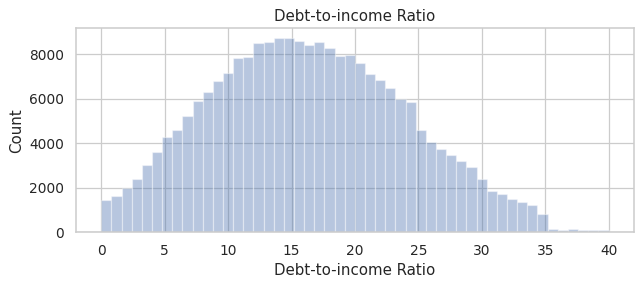

In [155]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull(), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

Very few. Compare the summary statistics by loan status:

In [78]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,18.220,7.8231,0.0,12.48,18.22,23.86,39.98
Fully Paid,184739.0,15.938,7.5699,0.0,10.31,15.58,21.25,39.99


Completed loans that are charged off tend to have higher debt-to-income ratios.

### 3.2.18 earliest_cr_line

Data Dictionary: "Bulan dimana batas kredit paling awal yang dilaporkan peminjam dibuka."

In [79]:
loans['earliest_cr_line'].sample(5)

247646    Aug-2006
13521     Nov-1994
188525    Mar-1998
34652     Jan-1979
432576    Sep-2002
Name: earliest_cr_line, dtype: object

In [80]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [81]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [82]:
loans['earliest_cr_line'].describe()

count    227214.0000
mean       1997.4821
std           6.9489
min        1946.0000
25%        1994.0000
50%        1999.0000
75%        2002.0000
max        2011.0000
Name: earliest_cr_line, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


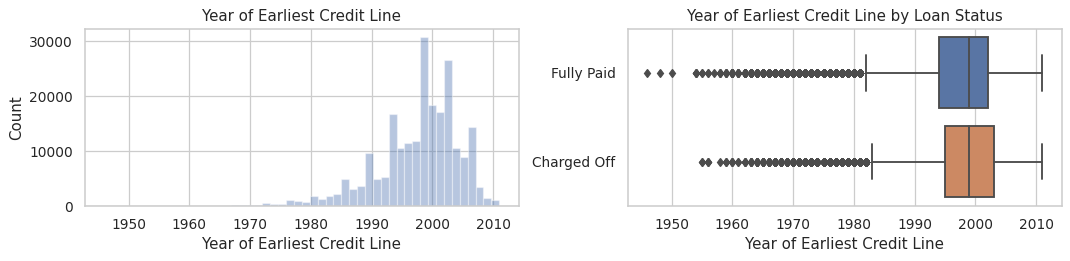

In [83]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Peminjam yang ditagih cenderung memiliki jalur kredit yang lebih pendek.

### 3.2.19 open_acc

Data Dictionary: "Jumlah jalur kredit terbuka dalam file kredit peminjam."

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Open Credit Lines')

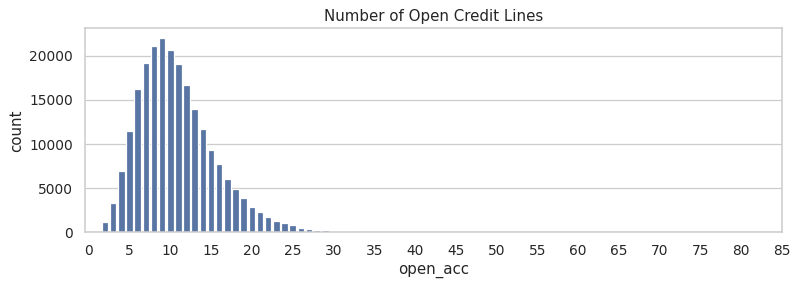

In [84]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans['open_acc'], order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Apakah ada perbedaan jumlah jalur kredit antara pinjaman yang dibayar penuh dan pinjaman yang dibebankan?

In [85]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,10.9993,4.8879,0.0,8.0,10.0,14.0,76.0
Fully Paid,184739.0,10.7944,4.7768,0.0,7.0,10.0,13.0,58.0


### 3.2.20 pub_rec

Data Dictionary: "Number of derogatory public records."

In [86]:
loans['pub_rec'].value_counts().sort_index()

0.0     201239
1.0      23165
2.0       1980
3.0        522
4.0        163
5.0         78
6.0         35
7.0         16
8.0          5
9.0          5
10.0         5
11.0         1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [87]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,0.1391,0.4335,0.0,0.0,0.0,0.0,9.0
Fully Paid,184739.0,0.1315,0.4144,0.0,0.0,0.0,0.0,11.0


### 3.2.21 revol_bal

Data Dictionary: "Total credit revolving balance."

In [88]:
loans['revol_bal'].describe()

count    2.2721e+05
mean     1.5073e+04
std      1.8125e+04
min      0.0000e+00
25%      5.9290e+03
50%      1.1000e+04
75%      1.9047e+04
max      1.7467e+06
Name: revol_bal, dtype: float64

Do a log transform:

In [89]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [90]:
loans.drop('revol_bal', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


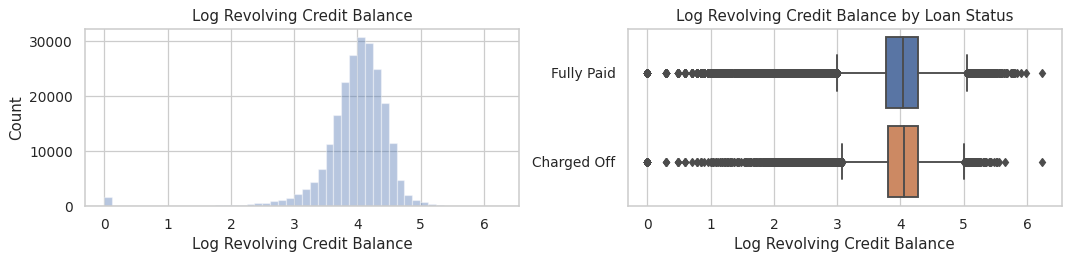

In [91]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [92]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,3.9863,0.5324,0.0,3.7986,4.056,4.2819,6.2422
Fully Paid,184739.0,3.9652,0.5653,0.0,3.7671,4.038,4.2794,6.2414


There isn't a large difference in the means.

### 3.2.22 revol_util

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [93]:
# Let's remove % percent sign from `revol_util` and convert it into `float`
loans.revol_util = loans.revol_util.map(lambda x: str(x).replace('%','')).astype(np.float64)
loans['revol_util'].head()

0    83.7
1     9.4
2    98.5
3    21.0
5    28.3
Name: revol_util, dtype: float64

In [94]:
loans['revol_util'].describe()

count    227028.0000
mean         54.8411
std          24.6936
min           0.0000
25%          37.0000
50%          56.5000
75%          74.3000
max         892.3000
Name: revol_util, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


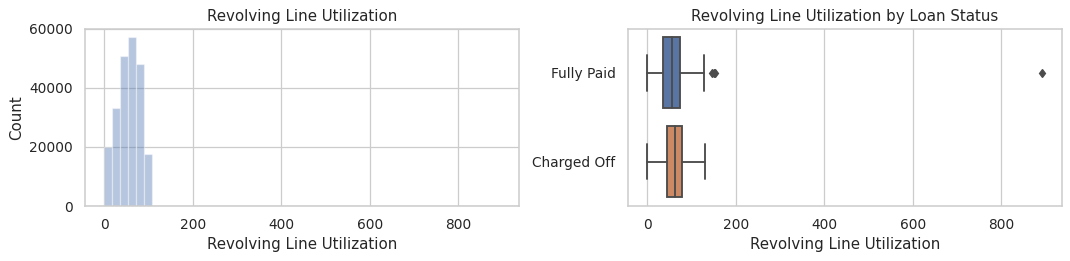

In [95]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [96]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42428.0,59.6802,23.3522,0.0,43.7,61.9,78.1,129.4
Fully Paid,184600.0,53.7289,24.8590,0.0,35.6,55.2,73.3,892.3


### 3.2.23 total_acc

Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Total Number of Credit Lines')

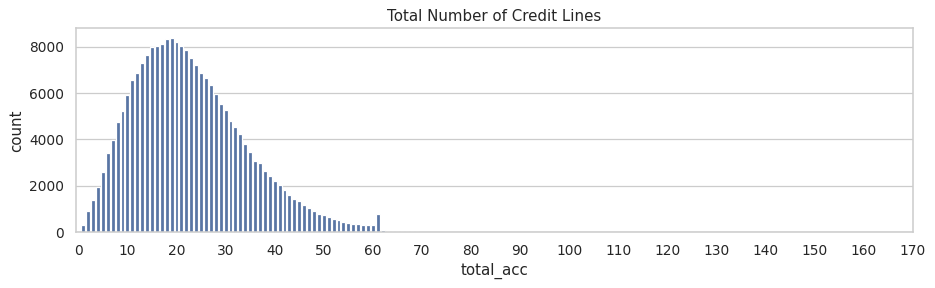

In [97]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [98]:
loans.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,24.1414,11.4619,2.0,16.0,23.0,31.0,94.0
Fully Paid,184739.0,24.9687,11.6514,2.0,16.0,23.0,32.0,150.0


No large differences here.

### 3.2.24 initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


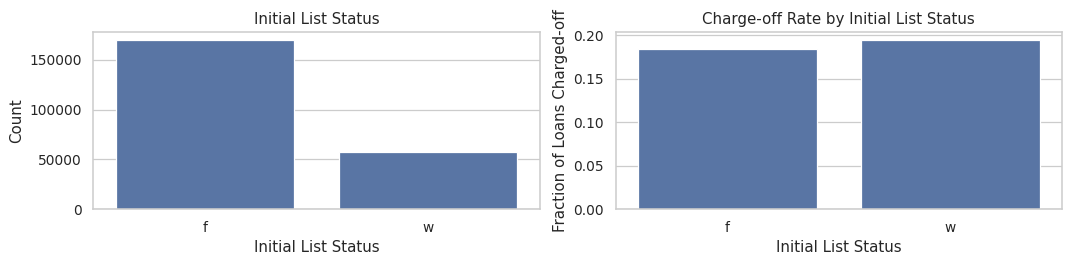

In [99]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

### 3.2.25 application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [100]:
loans['application_type'].value_counts()

INDIVIDUAL    227214
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [101]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
INDIVIDUAL    0.1869
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

<a id="4"></a>
# 4. More Pre-processing

<a id="4.1"></a>
## 4.1 Convert loan status to 0/1 charge-off indicator

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [102]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [103]:
loans = loans.dropna().reset_index(drop=True)

<a id="4.2"></a>
## 4.2 Create dummy variables

How many variables do we currently have?

In [104]:
loans.shape

(227028, 21)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [105]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [106]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

Series([], dtype: float64)


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [107]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'verification_status', 'issue_d', 'purpose',
       'addr_state', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'log_annual_inc', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [108]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [109]:
loans.shape

(227028, 116)

Check our data with the new dummy variables:

In [110]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,log_annual_inc,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
104831,8100,36,13.11,273.36,Jan-2013,33.92,2001,7.0,0.0,96.8,50.0,4.4397,4.2932,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
143472,8000,36,12.12,266.18,Jun-2012,15.35,1999,10.0,0.0,74.3,25.0,4.8633,4.2156,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
118399,14700,36,12.12,489.10,Nov-2012,25.20,1994,6.0,0.0,71.6,10.0,4.6532,4.5177,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25451,7000,36,11.49,230.80,Jul-2010,22.52,1991,4.0,0.0,87.6,7.0,4.5106,3.8674,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
124837,8400,36,7.90,262.84,Oct-2012,34.25,2007,9.0,0.0,39.1,11.0,4.5855,3.6340,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<a id="4.3"></a>
## 4.3 Train/test split

In [111]:
# We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.
# loans['issue_d'].sample(5)

# Are there any missing values?
# loans['issue_d'].isnull().any()

# No. Let's convert the issue dates to datetime objects:
# loans['issue_d'] = pd.to_datetime(loans['issue_d'])
# loans['issue_d'].sample(5)

# The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:
# loans['issue_d'].describe()
# There are only 154 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in March 2020. The busiest month was March 2016 with 57,553 loans funded in that month. What is the distribution of loans funded in each year?

# plt.figure(figsize=(6,3), dpi=90)
# loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
# plt.xlabel('Year')
# plt.ylabel('Number of Loans Funded')
# plt.title('Loans Funded per Year')

# We'll form the test set from the most recent 10% of the loans.

# loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
# loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]
# Refer [this video](https://www.youtube.com/watch?v=idXEk3MjC9M) if you didn't understood the quantile. Check that we properly partitioned the loans:

# What is the test size?
# loans_test.shape[0] / loans.shape[0]
# About 10.8%. The partition looks good, so we can delete the original `loans` dataframe:
# The training set includes loans from June 2007 to April 2018. The test set includes loans from May 2018 to March 2020. Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

# del loans

# loans_train.drop('issue_d', axis=1, inplace=True)
# loans_test.drop('issue_d', axis=1, inplace=True)

# del loans_train, loans_test

# y_train = loans_train['charged_off']
# y_test = loans_test['charged_off']

# X_train = loans_train.drop('charged_off', axis=1)
# X_test = loans_test.drop('charged_off', axis=1)

In [112]:
loans.drop('issue_d', axis=1, inplace=True)

In [113]:
# Features
X = loans.drop('charged_off',axis=1)

# Label
y = loans['charged_off']

In [114]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [115]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape:  ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape:  ", y_test.shape)

X_train.shape:  (181622, 114)
X_test.shape:   (45406, 114)
y_train.shape:  (181622,)
y_test.shape:   (45406,)


<a id="5"></a>
# 5. Linear Dependence of Charge-off on the Predictors

On the training set, we compute the [Pearson correlation](https://www.youtube.com/watch?v=6fUYt1alA1U), $F$-statistic, and $p$ value of each predictor with the response variable `charged_off`.

In [116]:
linear_dep = pd.DataFrame()

<a id="5.1"></a>
## 5.1 Pearson correlation
Kami menggunakan koefisien korelasi Pearson untuk menguji kekuatan dan arah hubungan linier antara dua variabel kontinu.

Koefisien korelasi dapat berkisar dalam nilai dari 1 hingga +1. Semakin besar nilai absolut koefisien, semakin kuat hubungan antar variabel. Untuk korelasi Pearson, nilai mutlak 1 menunjukkan hubungan linier yang sempurna. Korelasi yang mendekati 0 menunjukkan tidak ada hubungan linier antar variabel.

Tanda koefisien menunjukkan arah hubungan. Jika kedua variabel cenderung naik atau turun bersama-sama, koefisiennya positif, dan garis yang mewakili korelasi miring ke atas. Jika satu variabel cenderung meningkat sementara yang lain menurun, koefisiennya negatif, dan garis yang menunjukkan korelasi miring ke bawah.

Kita bisa melihat korelasi yang kuat antara loan_amnt dan cicilan. (Pembayaran bulanan terutang oleh peminjam jika pinjaman berasal)
Selengkapnya tentang teks sumber ini

In [117]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

In [118]:
linear_dep

,pearson_corr,abs_pearson_corr
loan_amnt,6.2143e-02,6.2143e-02
term,1.6262e-01,1.6262e-01
int_rate,2.4298e-01,2.4298e-01
installment,4.5240e-02,4.5240e-02
dti,1.1654e-01,1.1654e-01
earliest_cr_line,3.1539e-02,3.1539e-02
open_acc,1.7890e-02,1.7890e-02
pub_rec,7.0066e-03,7.0066e-03
revol_util,9.4384e-02,9.4384e-02
total_acc,-2.6475e-02,2.6475e-02


$F$-statistics:

In [119]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [120]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [121]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [122]:
linear_dep.head(30)

,variable,pearson_corr,F,p_value
0,int_rate,0.2430,11395.9061,0.0000e+00
1,term,0.1626,4933.1799,0.0000e+00
2,dti,0.1165,2500.7705,0.0000e+00
3,revol_util,0.0944,1632.4814,0.0000e+00
4,log_annual_inc,-0.0909,1512.8818,0.0000e+00
5,sub_grade_A4,-0.0653,777.8023,8.3155e-171
6,loan_amnt,0.0621,704.0825,7.6626e-155
7,sub_grade_A3,-0.0583,620.0778,1.2215e-136
8,sub_grade_A2,-0.0575,601.8404,1.0971e-132
9,sub_grade_A5,-0.0563,578.2370,1.4379e-127


The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), debt-to-income ratio, Revolving line utilization rate, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [123]:
linear_dep.tail(20)

,variable,pearson_corr,F,p_value
94,addr_state_ID,-2.2531e-03,0.9220,0.3369
95,addr_state_VT,-2.0752e-03,0.7821,0.3765
96,addr_state_KY,2.0699e-03,0.7781,0.3777
97,addr_state_AR,2.0491e-03,0.7625,0.3825
98,purpose_renewable_energy,1.8454e-03,0.6185,0.4316
99,addr_state_PA,1.7361e-03,0.5474,0.4594
100,addr_state_MN,1.6790e-03,0.5121,0.4742
101,purpose_educational,-1.2474e-03,0.2826,0.5950
102,addr_state_UT,-1.2231e-03,0.2717,0.6022
103,addr_state_ME,-1.1266e-03,0.2305,0.6312


It looks like the borrower's other home ownership, several of the address state, and several of the loan purposes are irrelevant for predicting charge-off.

<a id="6"></a>
# 6. Model Training and Testing

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Neural Network
2. Logistic regression with SGD training
3. Random forest

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

<a id="6.1"></a>
## 6.1 Neural Network

In [124]:
scaler = MinMaxScaler()

# fit and transfrom
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# everything has been scaled between 1 and 0
print('Max: ',X_train.max())
print('Min: ', X_train.min())

Max:  1.0
Min:  0.0


In [125]:
model = Sequential()

# input layer
model.add(Dense(X_train.shape[1],activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39,activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer="adam", loss='binary_crossentropy')

In [126]:
# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [127]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=400,
          verbose = 2,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

Epoch 1/400
710/710 - 4s - loss: 0.4626 - val_loss: 0.4407 - 4s/epoch - 5ms/step
Epoch 2/400
710/710 - 2s - loss: 0.4493 - val_loss: 0.4389 - 2s/epoch - 3ms/step
Epoch 3/400
710/710 - 2s - loss: 0.4470 - val_loss: 0.4377 - 2s/epoch - 3ms/step
Epoch 4/400
710/710 - 3s - loss: 0.4445 - val_loss: 0.4379 - 3s/epoch - 4ms/step
Epoch 5/400
710/710 - 2s - loss: 0.4434 - val_loss: 0.4396 - 2s/epoch - 3ms/step
Epoch 6/400
710/710 - 2s - loss: 0.4423 - val_loss: 0.4378 - 2s/epoch - 3ms/step
Epoch 7/400
710/710 - 2s - loss: 0.4408 - val_loss: 0.4383 - 2s/epoch - 3ms/step
Epoch 8/400
710/710 - 2s - loss: 0.4405 - val_loss: 0.4381 - 2s/epoch - 3ms/step
Epoch 9/400
710/710 - 2s - loss: 0.4389 - val_loss: 0.4379 - 2s/epoch - 3ms/step
Epoch 10/400
710/710 - 2s - loss: 0.4377 - val_loss: 0.4385 - 2s/epoch - 3ms/step
Epoch 11/400
710/710 - 2s - loss: 0.4371 - val_loss: 0.4387 - 2s/epoch - 3ms/step
Epoch 12/400
710/710 - 2s - loss: 0.4359 - val_loss: 0.4387 - 2s/epoch - 3ms/step
Epoch 13/400
710/710 - 3s

In [128]:
losses = pd.DataFrame(model.history.history)

In [129]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

print('Classification Report:')
print(classification_report(y_test, predictions))
print('\n')
print('Confusion Matirx:')
print(confusion_matrix(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     37000
           1       0.48      0.06      0.11      8406

    accuracy                           0.81     45406
   macro avg       0.65      0.52      0.50     45406
weighted avg       0.76      0.81      0.75     45406



Confusion Matirx:
[[36455   545]
 [ 7893   513]]


In [130]:
rnd.seed(101)
random_ind = rnd.randint(0,len(loans))

new_customer = loans.drop('charged_off',axis=1).iloc[random_ind]
new_customer

loan_amnt                              16000.0000
term                                      36.0000
int_rate                                   6.0300
installment                              486.9700
dti                                        7.1200
earliest_cr_line                        1999.0000
open_acc                                   6.0000
pub_rec                                    0.0000
revol_util                                 5.3000
total_acc                                 13.0000
log_annual_inc                             4.6532
log_revol_bal                              3.2125
sub_grade_A2                               0.0000
sub_grade_A3                               0.0000
sub_grade_A4                               0.0000
sub_grade_A5                               0.0000
sub_grade_B1                               0.0000
sub_grade_B2                               0.0000
sub_grade_B3                               0.0000
sub_grade_B4                               0.0000


In [131]:
# we need to reshape this to be in the same shape of the training data that the model was trained on
#model.predict_classes(new_customer.values.reshape(1,X_train.shape[1]))

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [132]:
# the prediction was right
loans.iloc[random_ind]['charged_off']

0.0

<a id="6.2"></a>
## 6.2 Logistic regression with SGD training

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

The machine learning pipeline:

In [133]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [134]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [135]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [136]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=1,
             param_grid={'model__alpha': [1e-05, 0.01, 10],
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [137]:
grid_sgdlogreg.best_score_

0.7058986134514915

Best hyperparameters:

In [138]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

<a id="6.3"></a>
## 6.3 Random forest classifier

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [139]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [140]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

In [141]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [142]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=1, param_grid={'model__n_estimators': [50]}, pre_dispatch=1,
             scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the random forest:

In [143]:
grid_rfc.best_score_

0.6865433297808886

Not quite as good as logistic regression, at least according to this metric.

<a id="6.4"></a>
## 6.4 Tune hyperparameters on the chosen model more finely

The three models performed quite similarly according to the AUROC:

In [144]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')

Cross-validated AUROC scores
0.7058986134514915 - Logistic regression
0.6865433297808886 - Random forest


Logistic regression squeaked out ahead, and coupled with the fact that `SGDClassifier` trains much faster than the other two models, we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [145]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

print(param_grid_sgdlogreg)

{'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]), 'model__penalty': ['l1', 'l2']}


In [146]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [147]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=1,
             param_grid={'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]),
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [148]:
grid_sgdlogreg.best_score_

0.7058986134514915

Best hyperparameters:

In [149]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

By some coincidence, the optimal hyperparameters here are the same as from our first grid search for logistic regression!

<a id="6.5"></a>
## 6.5 Test set evaluation

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [150]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.6941061211104039

The test set AUROC score is somewhat lower than the cross-validated score (0.694).

<a id="7"></a>
# 7. Conclusion

Kami menerapkan metode machine learning untuk memprediksi kemungkinan pinjaman yang diminta di perusahaan akan dilunasi. Setelah melatih dan mengevaluasi tiga model yang berbeda (regresi logistik, random forest, dan k-nearest neighbors), kami menemukan bahwa ketiganya melakukan hal yang sama menurut cross-validated AUROC pada data training. Kami memilih regresi logistik (dengan ridge penalty) karena ini adalah model tercepat untuk training, dan model ini memperoleh skor AUROC 0,694 pada set pengujian yang terdiri dari 10% pinjaman terbaru.

Model ini, meskipun jauh dari sempurna, dapat memberikan prediksi yang agak terinformasi tentang kemungkinan pinjaman akan dilunasi, hanya dengan menggunakan data yang tersedia bagi calon investor sebelum pinjaman didanai sepenuhnya.

Kami juga menemukan bahwa, menurut ukuran korelasi linier antara prediktor dan respons, variabel terpenting untuk memprediksi charge-off adalah interest rate dan term, revolving utilization dan debt-to-income ratio.